Found 1770 images belonging to 2 classes.
Found 269 images belonging to 2 classes.
Found 1770 images belonging to 2 classes.
Found 269 images belonging to 2 classes.
94765736/94765736 [==============================] - 6s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472    

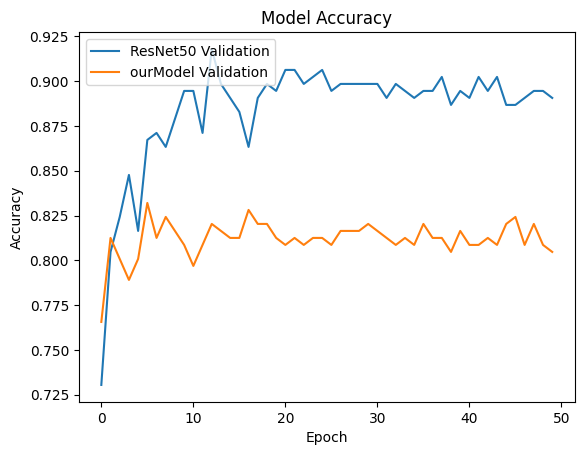

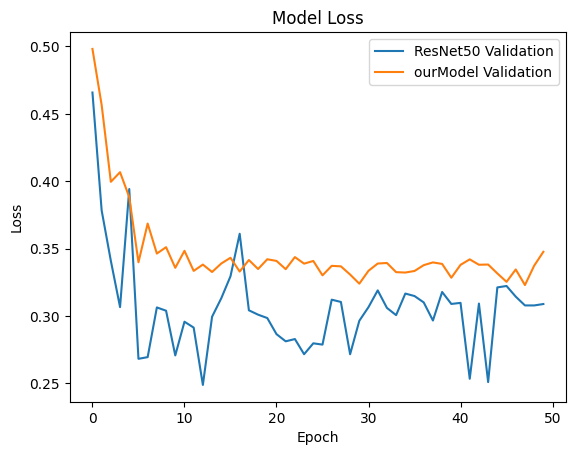

In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from zipfile import ZipFile

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Activation, GlobalAvgPool2D, concatenate, MaxPooling2D, Dense, \
    Conv2D, Flatten, GlobalAveragePooling2D

with ZipFile('/content/snake.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

train_path = '/content/train/'
test_path = '/content/test/'

# 데이터 로드 함수
def dataLoad(train_path, test_path, batch_size):
    # train 데이터 증강
    train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rotation_range=20,
                                       width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                                       horizontal_flip=True, vertical_flip=True, fill_mode='nearest')

     #test 데이터 증강
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    # train 데이터 불러오기
    train_set = train_datagen.flow_from_directory(train_path,
                                                 target_size=(224, 224),
                                                 batch_size=batch_size,
                                                 shuffle=True,
                                                 class_mode='categorical')

    # test 데이터 불러오기
    test_set = test_datagen.flow_from_directory(test_path,
                                                target_size=(224, 224),
                                                batch_size=batch_size,
                                                shuffle=True,
                                                class_mode='categorical')

    return train_set, test_set

batch_size = 16
train_set, test_set = dataLoad(train_path, test_path, batch_size)

# 모델 정의 함수
def myModel(input_shape=(224, 224, 3)):
    # ResNet50 불러오기
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # 레어어 쌓기
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    x1 = Dense(1024, activation='relu')(x)
    x1 = Dense(1024, activation='relu')(x1)

    x2 = Dense(1024, activation='relu')(x)
    x2 = Dense(1024, activation='relu')(x2)

    x3 = Dense(1024, activation='relu')(x)
    x3 = Dense(1024, activation='relu')(x3)

    x4 = Dense(1024, activation='relu')(x)
    x4 = Dense(1024, activation='relu')(x4)

    x = concatenate([x, x1, x2, x3, x4], axis=-1)
    x = Dense(4096, activation='relu')(x)

    predictions = Dense(2, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    #ResNet50의 가중치 고정
    for layer in base_model.layers: layer.trainable = False

    return model

# ResNet50 모델을 이용해 새로운 모델 생성하는 함수
def myResNet(input_shape=(224, 224, 3)):
    model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in model.layers: layer.trainable = False

    x = model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(2, activation='softmax')(x)

    return Model(inputs=model.input, outputs=predictions)

# 모델 학습 및 평가하는 함수
def train_model(train_path, test_path, batch_size=16, epochs=100):
    train_set, test_set = dataLoad(train_path, test_path, batch_size)

    model = myModel()
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

    model.summary()

    # 모델 성능 개선
    checkpoint_path = 'best_model.h5'
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6)

    # 모델 학습
    hist = model.fit(train_set,
                     steps_per_epoch=train_set.samples // batch_size,
                     epochs=epochs,
                     validation_data=test_set,
                     validation_steps=test_set.samples // batch_size,
                     callbacks=[checkpoint, reduce_lr])

    model.load_weights(checkpoint_path)

    # 모델 평가
    resnet50_accuracy = model.evaluate(test_set)[1]

    # ourModel 생성 및 학습
    ourmodel = myResNet()
    ourmodel.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
    ourmodel.summary()

    ourmodel_checkpoint_path = 'ourmodel_best_model.h5'
    ourmodel_checkpoint = ModelCheckpoint(ourmodel_checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)
    ourmodel_reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6)

    ourmodel_hist = ourmodel.fit(train_set,
                                 steps_per_epoch=train_set.samples // batch_size,
                                 epochs=epochs,
                                 validation_data=test_set,
                                 validation_steps=test_set.samples // batch_size,
                                 callbacks=[ourmodel_checkpoint, ourmodel_reduce_lr])

    ourmodel.load_weights(ourmodel_checkpoint_path)

    # 모델 평가
    ourmodel_accuracy = ourmodel.evaluate(test_set)[1]

    # 결과 출력
    print("ResNet50 Accuracy:", resnet50_accuracy)
    print("ourModel Accuracy:", ourmodel_accuracy)


    # Accuracy 그래프 그리기
    plt.plot(hist.history['val_accuracy'])
    plt.plot(ourmodel_hist.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['ResNet50 Validation',  'ourModel Validation'], loc='upper left')
    plt.show()

    # Loss 그래프 그리기
    plt.plot(hist.history['val_loss'])
    plt.plot(ourmodel_hist.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['ResNet50 Validation', 'ourModel Validation'], loc='upper right')
    plt.show()

    return hist

# 모델 학습 및 결과 저장
epochs, batch_size = 100, 16
hist = train_model(train_path, test_path, batch_size, epochs)
